In [1]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output

sys.path.append('..')
sys.path.append('../task_02')

from dataset import Pipeline, DatasetIndex, Dataset, B, V

from dataset.opensets import MNIST
from dataset.models.tf import UNet, LinkNet, VGG7, ResNetAttention56
from noised_mnist import NoisedMnist                                          # Batch subclass with loading and noise actions
from plot_functions import plot_noised_image, plot_examples_highlighted       # plot functions to demonstrate result 

In [2]:
IMAGE_SIZE = 64     # image size
MNIST_SIZE = 65000  # MNIST database size
BATCH_SIZE = 32     # batch size for NN training
MAX_ITER = 100      # number of iterations for NN training

In [3]:
level = 0.2           # the highest level of noise; [0, 1]
n_fragments = 80    # number of noise fragments per image  
size = 4            # size of noise fragment; 1, ..., 27
distr = 'uniform'   # distribution of fragments of image; 'uniform' or 'normal'

In [4]:
mnistset = MNIST(batch_class=NoisedMnist)

Extracting ExtractingExtractingExtractingC:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gz   
C:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gz




In [5]:
load_template = (Pipeline()
                 .random_location(IMAGE_SIZE)      # put MNIST at random location
                 .make_masks()                     # create mask for MNIST image location
                 .create_noise('mnist_noise', level, n_fragments, size, distr)
                 .add_noise())

In [6]:
placeholders_config = {
                       'images': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 1),
                                 'type': 'float32',
                                 'data_format': 'channels_last'},
                
                       'labels': {'classes': 10,
                                  'dtype': 'int32',
                                  'transform': 'ohe',
                                  'name': 'targets'}
                       }

In [7]:
model_config = {'inputs': placeholders_config,
                'input_block/inputs': 'images',
                'loss': 'softmax_cross_entropy',
                'output': {'ops': ['proba', 'accuracy']},
                'head/units': [100, 100, 2],
                'optimizer': 'Adam'}

train_feed_dict = {'images': B('images'),
                   'labels': B('labels')}        

test_feed_dict = {'images': B('images'),
                  'labels': B('labels')}

In [8]:
train_pp = ((load_template << mnistset.train)
            .init_model('static', ResNetAttention56, 'VGG', config=model_config)
            .init_variable('loss_history', init_on_each_run=list)
            .train_model('VGG', fetches=['loss'], feed_dict=train_feed_dict, save_to=V('loss_history'), mode='e'))

Tensor("ResNetAttention56/body/attention-1/attention_map:0", shape=(?, 8, 8, 256), dtype=float32)
Tensor("ResNetAttention56/body/attention-3/attention_map:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("ResNetAttention56/body/attention-5/attention_map:0", shape=(?, 2, 2, 1024), dtype=float32)


In [9]:
test_pp = ((load_template << mnistset.test)
            .import_model('VGG', train_pp)
            .init_variable('predicted_labels', init_on_each_run=list)
            .init_variable('acc', init_on_each_run=list)
            .predict_model('VGG', 
                           fetches=['predicted_labels', 'accuracy'], 
                           feed_dict=test_feed_dict, 
                           save_to=[V('predicted_labels'), V('acc')], 
                           mode='a'))

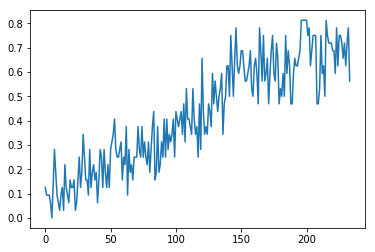

KeyboardInterrupt: 

In [10]:
for i in range(1000):
    train_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=False)
    batch = test_pp.next_batch(BATCH_SIZE, shuffle=True, n_epochs=None, drop_last=False)
    acc = test_pp.get_variable('acc')
    clear_output(True)
    
    plt.plot(acc)
    plt.show()

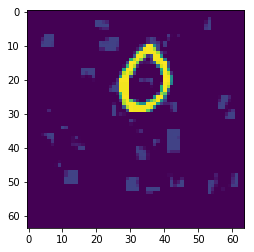

0 0


In [11]:
i = 6
image = np.squeeze(batch.data.images[i])
predictions = test_pp.get_variable('predicted_labels')[-1]
plt.imshow(image)
plt.show()
print(batch.data.labels[i], predictions[i])

In [14]:
maps = ['ResNetAttention56/body/attention-{}/attention_map:0'.format(i) for i in [1,3,5]]

ppl_for_maps = ((load_template << mnistset.test)
                .import_model('VGG', train_pp)
                .init_variable('predicted_labels', init_on_each_run=list)
                .init_variable('attention_maps', init_on_each_run=list)
                .predict_model('VGG', 
                               fetches=maps, 
                               feed_dict=test_feed_dict, 
                               save_to=V('attention_maps'), 
                               mode='a'))

In [29]:
batch = ppl_for_maps.next_batch(10)

In [35]:
mean_maps_1 = np.mean(ppl_for_maps.get_variable('attention_maps')[-1][0], axis=-1)
mean_maps_3 = np.mean(ppl_for_maps.get_variable('attention_maps')[-1][1], axis=-1)
mean_maps_5 = np.mean(ppl_for_maps.get_variable('attention_maps')[-1][2], axis=-1)

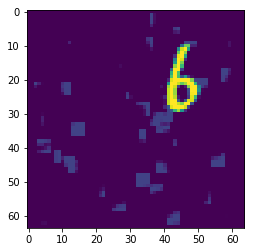

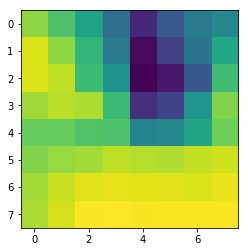

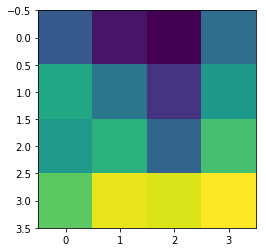

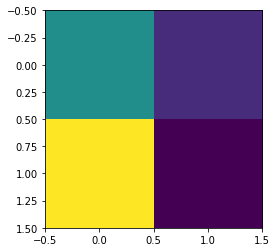

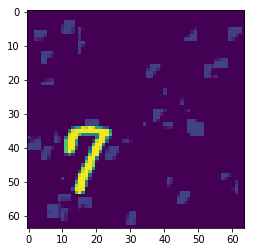

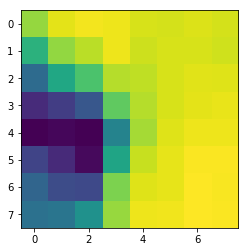

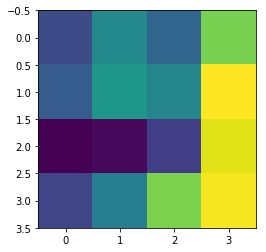

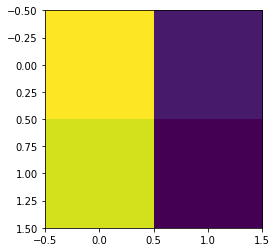

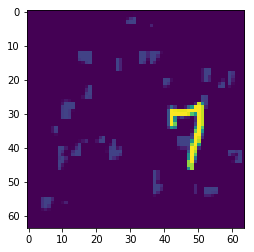

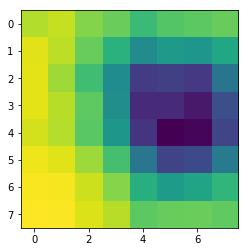

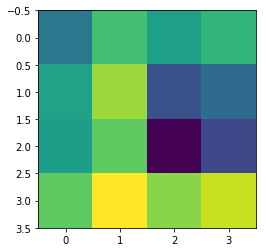

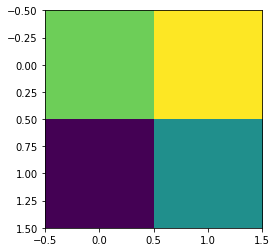

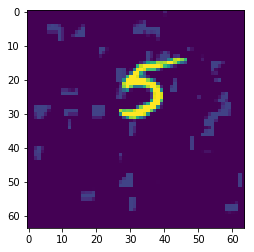

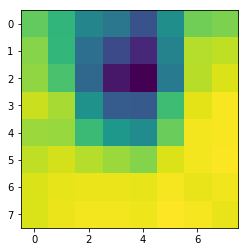

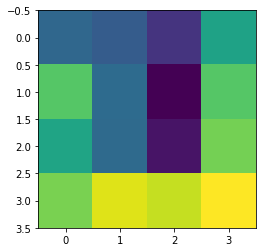

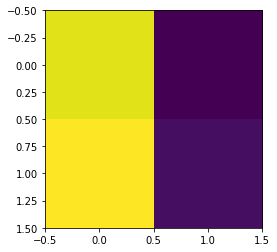

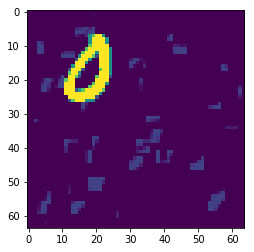

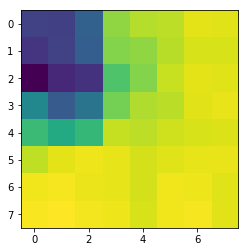

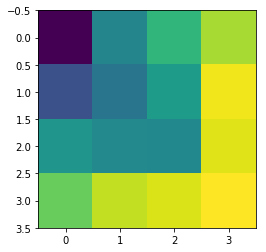

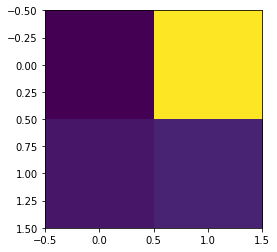

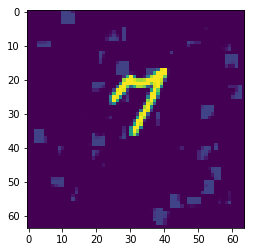

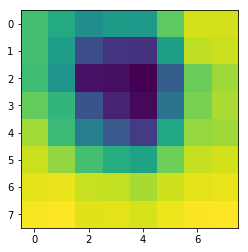

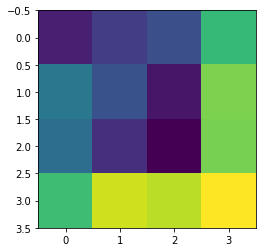

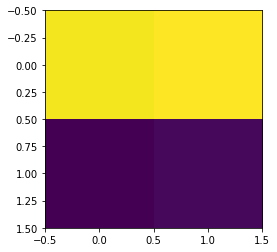

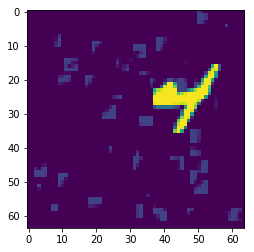

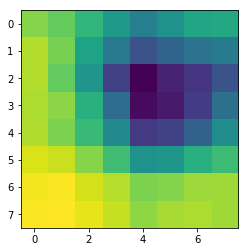

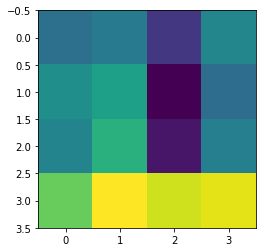

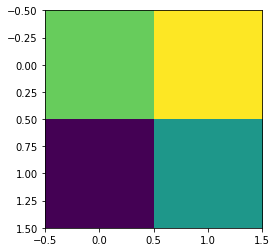

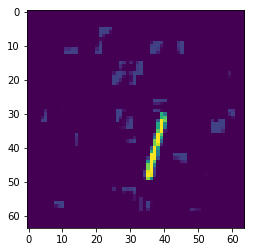

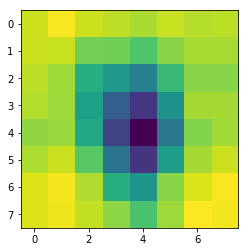

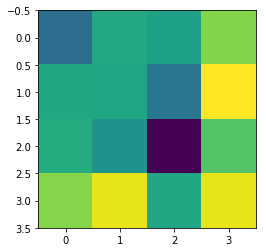

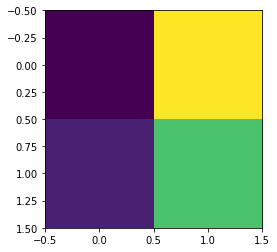

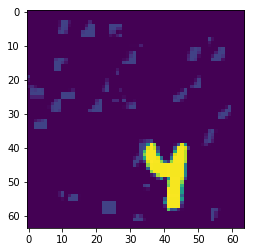

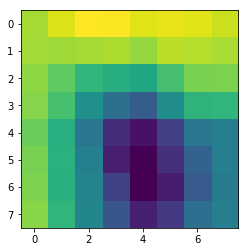

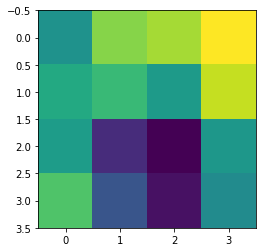

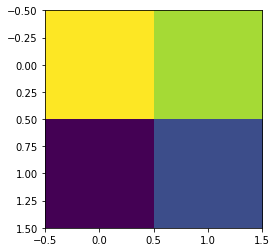

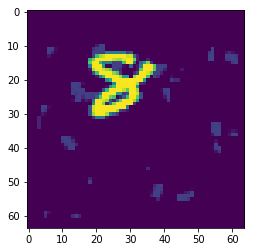

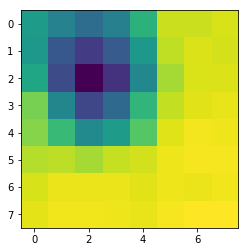

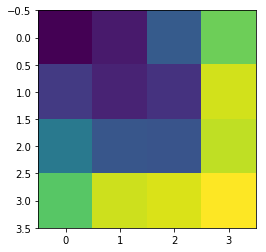

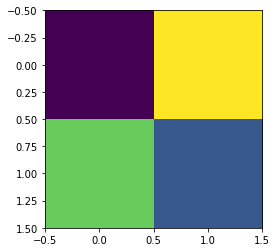

In [37]:
for i in range(10):
    plt.imshow(np.squeeze(batch.data.images[i]))
    plt.show()
    plt.imshow(mean_maps_1[i])
    plt.show()
    plt.imshow(mean_maps_3[i])
    plt.show()
    plt.imshow(mean_maps_5[i])
    plt.show()